### Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras import layers
# import shutil
# import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

import h5py

In [2]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
# Чистим папку, если что-то пошло не так
shutil.rmtree('/content/drive/MyDrive/course_work_nn/train')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create DataFrame

In [ ]:
!cd /content/drive/MyDrive/course_work_nn && unzip -q train.zip

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [4]:
# преобразуем имена файлов(убрать все кроме имени)
for i in range(len(df)):  
    df['image_path'][i] = df['image_path'][i].replace("./train/", "")

<ipython-input-4-edeccec4a1a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'][i] = df['image_path'][i].replace("./train/", "")


In [6]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,anger/0.jpg,anger
1,1,anger/1.jpg,anger
2,2,anger/10.jpg,anger
3,3,anger/100.jpg,anger
4,4,anger/1000.jpg,anger


In [5]:
class_weight = {}
for i, j  in enumerate(set(df.emotion)):
    count_of_samples = df[df['emotion'] == j].agg('count')[0]
    total = df.shape[0]
    weight = (1 / count_of_samples) * (total / 9.0)

    class_weight[i] = weight

In [6]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,0:2], df['emotion'], test_size=0.2, stratify=df['emotion'])

In [7]:
train = pd.concat([train_x, train_y], axis = 1).reset_index(drop=True)
test = pd.concat([test_x, test_y], axis = 1).reset_index(drop=True)

In [8]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(train.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_train = pd.concat([train, tmp], axis = 1)

In [9]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(test.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_test = pd.concat([test, tmp], axis = 1)

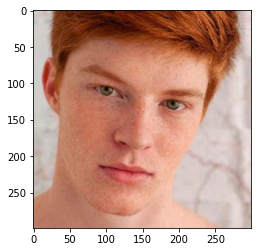

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/course_work_nn/train/anger/1000.jpg')
plt.imshow(img)

### DataGenerator

In [12]:
datagen = ImageDataGenerator(
         rotation_range=20,
#          brightness_range=(.1, .5),     
#          channel_shift_range=220,
         width_shift_range=0.1,  
         height_shift_range=0.1,
         zoom_range=0.1,
         fill_mode='nearest',
         rescale=1./255,
                             )

datagen_test = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


In [ ]:
# sample_images, sample_labels = next(train_generator_1)
# assert sample_images.shape == (64, 256, 256, 3), "Неправильный размер батча"
# print("Simple tests passed")
# print(sample_images.shape)

Simple tests passed
(64, 256, 256, 3)


### The first model + data augmentation

In [17]:
model01 = models.Sequential()

model01.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,3)))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.Flatten())
model01.add(tf.keras.layers.Dense(512, activation = 'relu'))
model01.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [18]:
model01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

In [19]:
model01.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main20.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

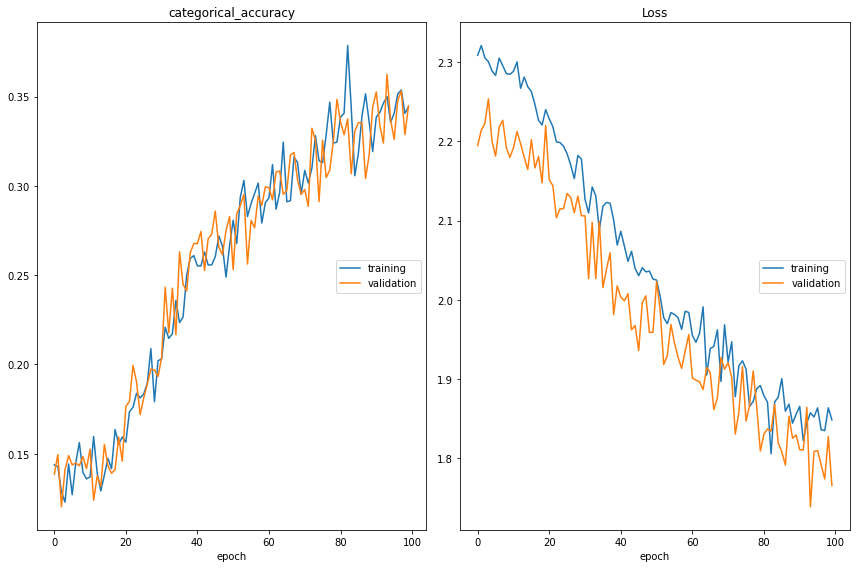

categorical_accuracy
	training         	 (min:    0.123, max:    0.379, cur:    0.344)
	validation       	 (min:    0.120, max:    0.363, cur:    0.345)
Loss
	training         	 (min:    1.805, max:    2.321, cur:    1.848)
	validation       	 (min:    1.739, max:    2.254, cur:    1.765)
30/30 [==============================] - 77s 3s/step - loss: 1.8483 - categorical_accuracy: 0.3443 - val_loss: 1.7654 - val_categorical_accuracy: 0.3448


In [22]:
history = model01.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

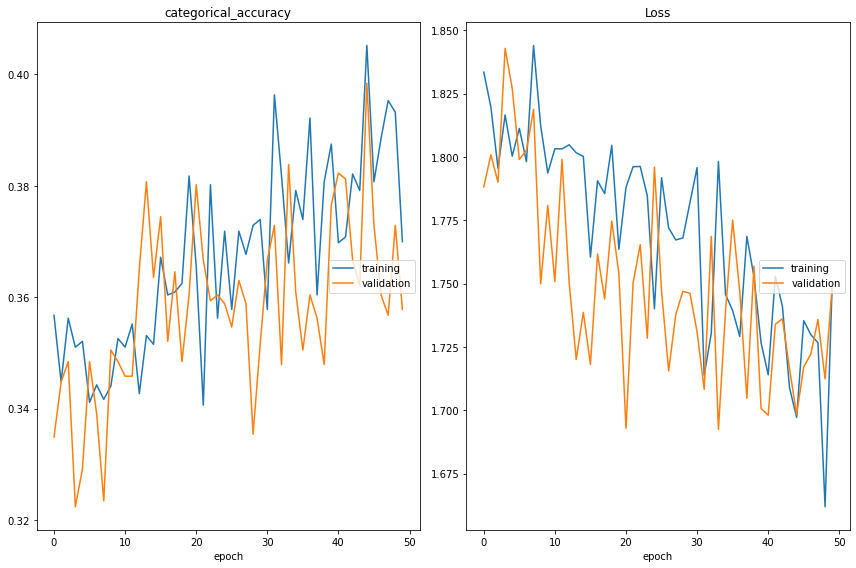

categorical_accuracy
	training         	 (min:    0.341, max:    0.405, cur:    0.370)
	validation       	 (min:    0.322, max:    0.398, cur:    0.358)
Loss
	training         	 (min:    1.662, max:    1.844, cur:    1.750)
	validation       	 (min:    1.692, max:    1.843, cur:    1.749)
30/30 [==============================] - 83s 3s/step - loss: 1.7501 - categorical_accuracy: 0.3700 - val_loss: 1.7488 - val_categorical_accuracy: 0.3578


In [23]:
history = model01.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 50,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)


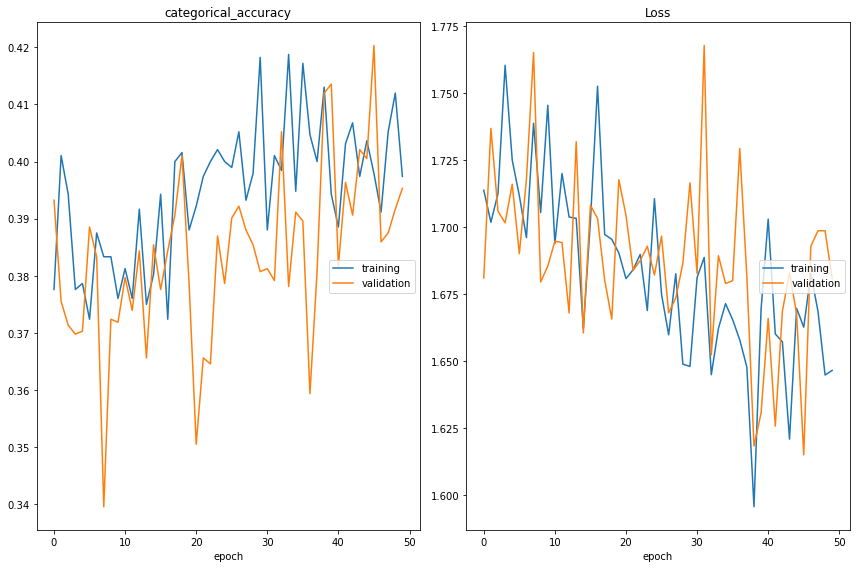

categorical_accuracy
	training         	 (min:    0.372, max:    0.419, cur:    0.397)
	validation       	 (min:    0.340, max:    0.420, cur:    0.395)
Loss
	training         	 (min:    1.596, max:    1.760, cur:    1.647)
	validation       	 (min:    1.615, max:    1.768, cur:    1.681)
30/30 [==============================] - 88s 3s/step - loss: 1.6466 - categorical_accuracy: 0.3974 - val_loss: 1.6809 - val_categorical_accuracy: 0.3953


In [24]:
history = model01.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 50,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)


### The second model with augmentation

In [ ]:
datagen = ImageDataGenerator(
         rotation_range=20,
#          brightness_range=(.1, .5),     
#          channel_shift_range=220,
#          width_shift_range=0.1,  
#          height_shift_range=0.1,
#          zoom_range=0.1,
#          fill_mode='nearest',
         rescale=1./255,
                             )

datagen_test = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

In [28]:
model02 = tf.keras.Sequential()

model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape = (128,128,3))) 
model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model02.add(tf.keras.layers.Flatten())
model02.add(tf.keras.layers.Dense(256, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                  bias_regularizer=regularizers.L2(1e-4),
                                  activity_regularizer=regularizers.L2(1e-5),
                                  activation='relu'))

model02.add(tf.keras.layers.Dense(9, activation='softmax'))

In [29]:
model02.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                 

In [30]:
model02.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [31]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main21.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

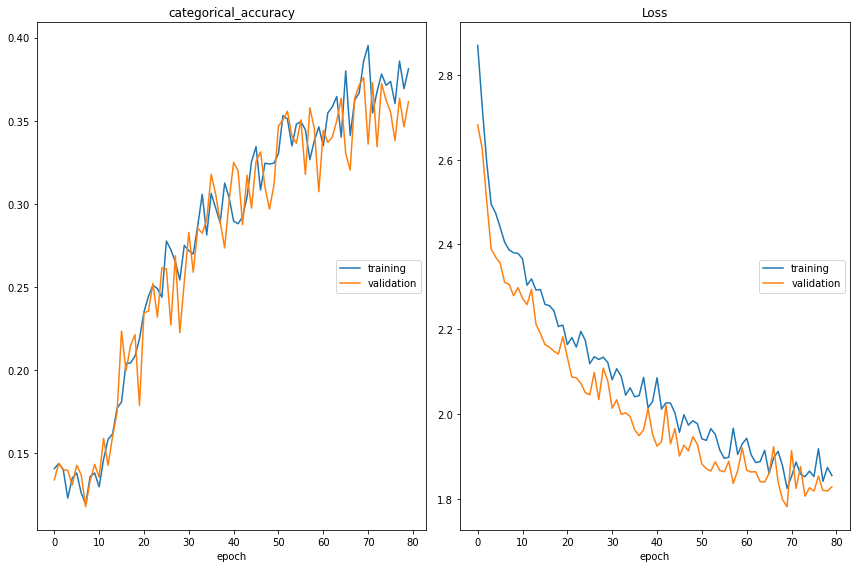

categorical_accuracy
	training         	 (min:    0.119, max:    0.395, cur:    0.381)
	validation       	 (min:    0.118, max:    0.376, cur:    0.361)
Loss
	training         	 (min:    1.824, max:    2.870, cur:    1.855)
	validation       	 (min:    1.781, max:    2.682, cur:    1.828)
30/30 [==============================] - 171s 6s/step - loss: 1.8549 - categorical_accuracy: 0.3812 - val_loss: 1.8283 - val_categorical_accuracy: 0.3615
Epoch 81/100


KeyboardInterrupt: 

In [32]:
history = model02.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### SeparableConv2D

In [39]:
model03 = models.Sequential()
model03.add(tf.keras.layers.SeparableConv2D(32, kernel_size=(3, 3), activation='relu', 
                                          input_shape=(128,128,3)))
model03.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model03.add(tf.keras.layers.Dropout(0.2))
model03.add(tf.keras.layers.SeparableConv2D(64, kernel_size=(3, 3), activation='relu'))
model03.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model03.add(tf.keras.layers.Dropout(0.2))
model03.add(tf.keras.layers.SeparableConv2D(128, kernel_size=(3, 3), activation='relu'))
model03.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model03.add(tf.keras.layers.Dropout(0.2))
model03.add(tf.keras.layers.Flatten())
model03.add(tf.keras.layers.Dense(256, activation='relu'))
model03.add(tf.keras.layers.Dense(9, activation='softmax'))

In [40]:
model03.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [37]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main23.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

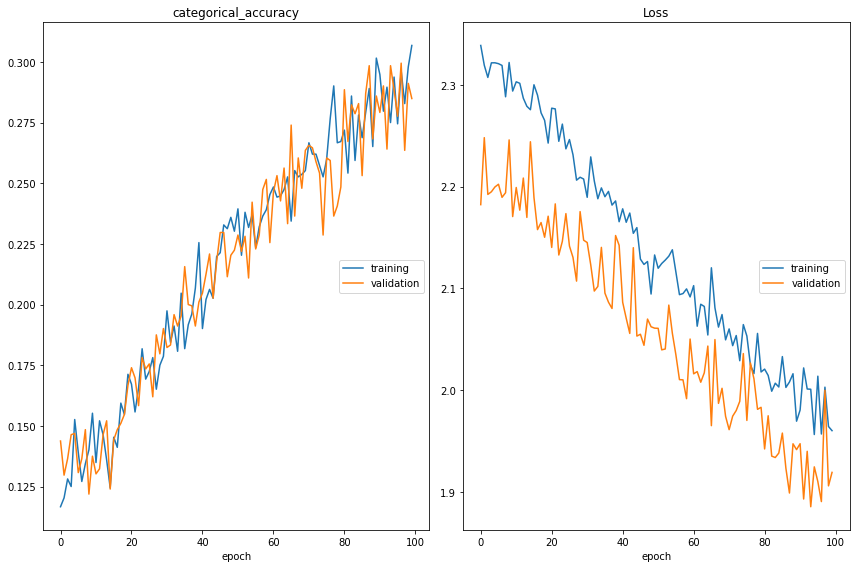

categorical_accuracy
	training         	 (min:    0.117, max:    0.307, cur:    0.307)
	validation       	 (min:    0.122, max:    0.299, cur:    0.285)
Loss
	training         	 (min:    1.956, max:    2.339, cur:    1.960)
	validation       	 (min:    1.885, max:    2.248, cur:    1.919)
30/30 [==============================] - 62s 2s/step - loss: 1.9601 - categorical_accuracy: 0.3068 - val_loss: 1.9191 - val_categorical_accuracy: 0.2849


In [41]:
history = model03.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

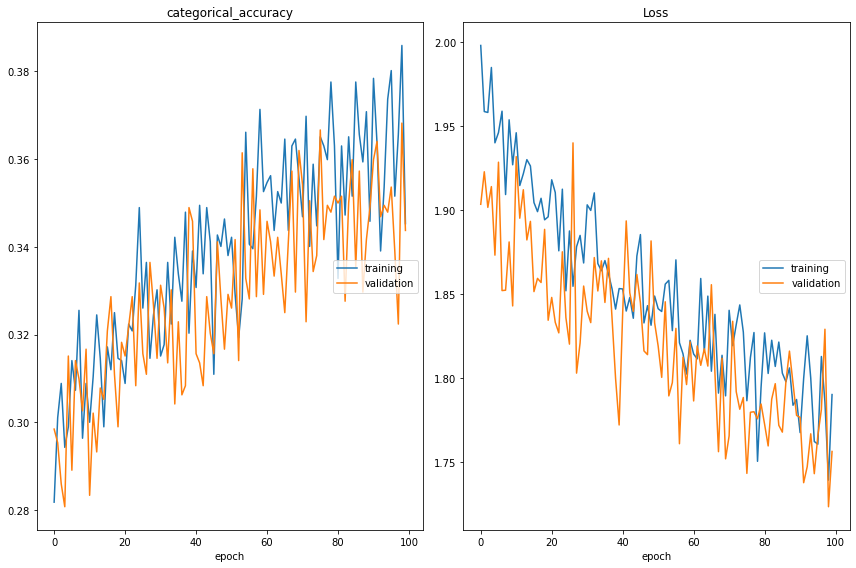

categorical_accuracy
	training         	 (min:    0.282, max:    0.386, cur:    0.345)
	validation       	 (min:    0.281, max:    0.368, cur:    0.344)
Loss
	training         	 (min:    1.739, max:    1.998, cur:    1.790)
	validation       	 (min:    1.723, max:    1.940, cur:    1.756)
30/30 [==============================] - 62s 2s/step - loss: 1.7902 - categorical_accuracy: 0.3453 - val_loss: 1.7564 - val_categorical_accuracy: 0.3438


In [42]:
history = model03.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### SeparableConv2D the second model

In [20]:
datagen = ImageDataGenerator(
         rotation_range=20,
#          brightness_range=(.1, .5),     
#          channel_shift_range=220,
#          width_shift_range=0.1,  
#          height_shift_range=0.1,
#          zoom_range=0.1,
#          fill_mode='nearest',
         rescale=1./255,
                             )

datagen_test = ImageDataGenerator(rescale = 1./255)

In [21]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


In [23]:
model05 = models.Sequential()
model05.add(layers.Conv2D(64,3,activation = 'relu', input_shape = (128,128,3)))
model05.add(layers.Conv2D(64,3,activation = 'relu'))
model05.add(layers.MaxPooling2D(2))
model05.add(layers.SeparableConv2D(128,3,activation = 'relu'))
model05.add(layers.SeparableConv2D(128,3,activation = 'relu'))
model05.add(layers.MaxPooling2D(2))
model05.add(layers.SeparableConv2D(256,3,activation = 'relu'))
model05.add(layers.BatchNormalization())
model05.add(layers.SeparableConv2D(256,3,activation = 'relu'))
model05.add(layers.BatchNormalization())
model05.add(layers.SeparableConv2D(256,3,activation = 'relu'))
model05.add(layers.MaxPooling2D(2))
model05.add(layers.SeparableConv2D(512,3,activation = 'relu'))
model05.add(layers.BatchNormalization())
model05.add(layers.SeparableConv2D(512,3,activation = 'relu'))
model05.add(layers.BatchNormalization())
model05.add(layers.SeparableConv2D(512,3,activation = 'relu'))
model05.add(layers.MaxPooling2D(2))
model05.add(layers.Flatten())
model05.add(tf.keras.layers.Dense(1024, 
                                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                  bias_regularizer=regularizers.L2(1e-4),
                                  activity_regularizer=regularizers.L2(1e-5),activation = 'relu'))
# model05.add(tf.keras.layers.Dropout(0.4))
model05.add(tf.keras.layers.Dense(512, 
                                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 activity_regularizer=regularizers.L2(1e-5),
                                  activation = 'relu'))
# model05.add(tf.keras.layers.Dropout(0.2))
model05.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [24]:
model05.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [25]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main25.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

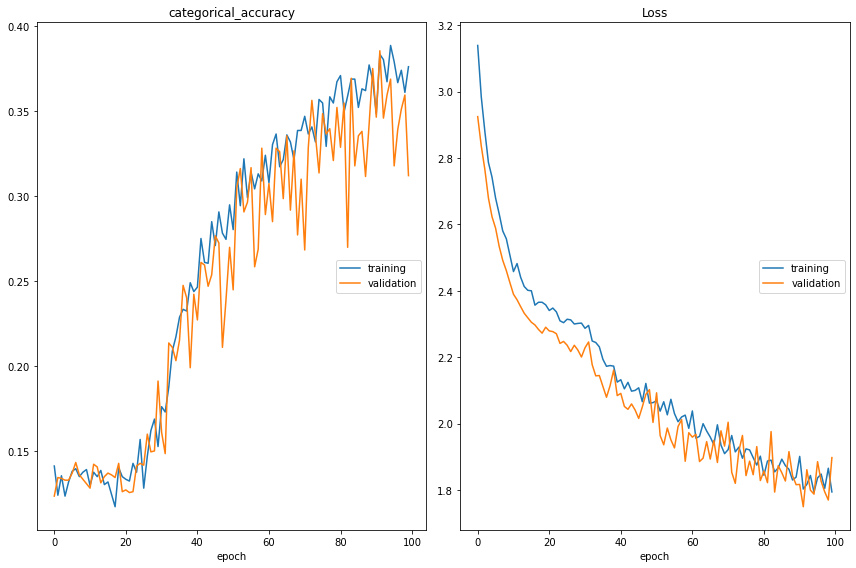

categorical_accuracy
	training         	 (min:    0.117, max:    0.389, cur:    0.376)
	validation       	 (min:    0.123, max:    0.385, cur:    0.312)
Loss
	training         	 (min:    1.794, max:    3.139, cur:    1.795)
	validation       	 (min:    1.750, max:    2.925, cur:    1.898)
30/30 [==============================] - 246s 8s/step - loss: 1.7945 - categorical_accuracy: 0.3760 - val_loss: 1.8979 - val_categorical_accuracy: 0.3120


In [26]:
history = model05.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

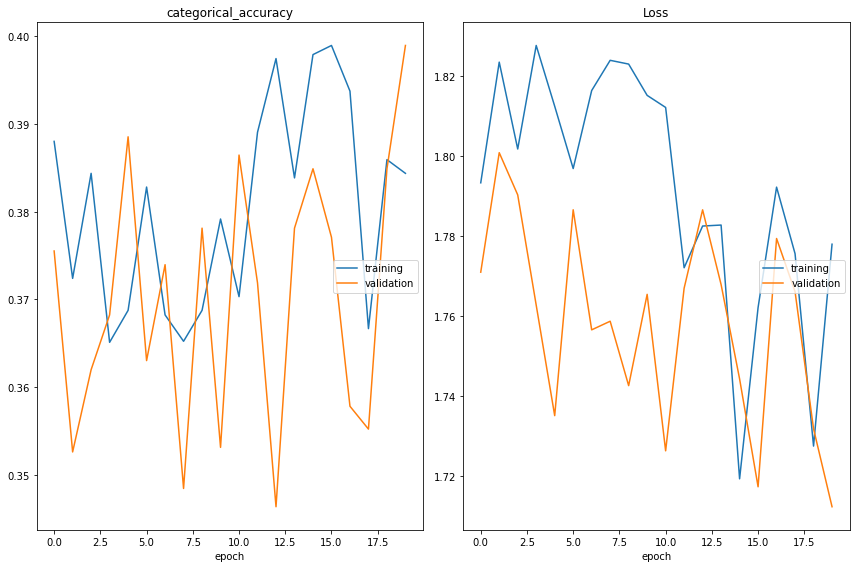

categorical_accuracy
	training         	 (min:    0.365, max:    0.399, cur:    0.384)
	validation       	 (min:    0.346, max:    0.399, cur:    0.399)
Loss
	training         	 (min:    1.719, max:    1.828, cur:    1.778)
	validation       	 (min:    1.712, max:    1.801, cur:    1.712)
30/30 [==============================] - 243s 8s/step - loss: 1.7780 - categorical_accuracy: 0.3844 - val_loss: 1.7123 - val_categorical_accuracy: 0.3990


In [27]:
history = model05.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 20,
                       validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### Vizualization

In [ ]:
def show_pred(images, labels, predicted_labels=None):
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(images[i])
        plt.imshow(img)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

In [ ]:
# predicted_labels = model.predict(test_generator_1)
idxs = np.random.choice(np.arange(len(test_generator_1.filenames)), 16, replace=False)
fnames = []
labels = []
preds = []
for i in idxs:
    fnames.append('/content/drive/MyDrive/course_work_nn/train/' + test_generator_1.filenames[i])
    labels.append(list(set(df['emotion']))[test_generator_1.labels[i]])
    preds.append(list(set(df['emotion']))[np.argmax(predicted_labels[i])])
show_pred(fnames, labels, preds)

### One foto inference

In [74]:
def preprocess_img(img):
    """препроцессинг фото перед подачей в сеть"""
    img = img.resize((128,128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    img = np.expand_dims(img, axis = 0)
    return img

In [83]:
import time
from tensorflow.keras.preprocessing import image

start = time.time()
img = image.load_img('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/test_kaggle/test_kaggle/1.jpg')
img = preprocess_img(img)
pred = model01.predict(img)
end = time.time()
print(end - start)

0.27200865745544434


In [ ]:
plt.set_title(emotions[np.argmax(pred)])
plt.imshow(img)

### Generating a file for Kaggle

In [ ]:
shutil.rmtree('/content/drive/MyDrive/course_work_nn/test_kaggle')

In [ ]:
!cd /content/drive/MyDrive/course_work_nn/ && unzip -q test_kaggle.zip

In [11]:
model01 = tf.keras.models.load_model('model_main20.h5')

In [48]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

In [40]:
datagen = ImageDataGenerator(rescale = 1/255.)

In [41]:
test_generator = datagen.flow_from_directory(directory = 'test_kaggle/test_kaggle/',
                                       target_size=(128,128),
                                       class_mode='categorical',
                                       classes=['.'],
                                       shuffle = False,
                                       batch_size=1)

Found 5000 images belonging to 1 classes.


In [65]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model01.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
    predictions.append(emotions[np.argmax(i)])

filenames = []
for i in test_generator.filenames:
    filn = i.replace(".\\",'')
    filenames.append(filn)

results=pd.DataFrame({"image_path":filenames,
                      "emotion":predictions})

5000/5000 [==============================] - 256s 51ms/step


In [66]:
results.to_csv('model_01_augmentation_.csv', index=False)